In [2]:
import os
os.chdir('../..')
!ls

future_trade


In [3]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import r2_score

pd.set_option('display.max_rows', 500)

In [4]:
regions = pd.read_csv('../../OPSIS/Data/Country_group/regions.csv')
regions.loc[regions['Region Name']=='Americas', 'Region Name'] = regions.loc[regions['Region Name']=='Americas']['Sub-region Name']
regions.loc[regions['Abbreviation']=='NOR', 'Region Name'] = 'Europe'
regions.loc[regions['Abbreviation']=='OAO', 'Region Name'] = 'Africa'
regions.loc[regions['Abbreviation']=='OIO', 'Region Name'] = 'Africa'
regions = regions[['Abbreviation', 'Region or country', 'Region Name']].drop_duplicates()                                                                                       
regions.shape

(158, 3)

In [5]:
SSP = 'SSP2'
data_dir = '../../OPSIS/Data/Trade_clearance_model'
calibration_output = f'{data_dir}/Output/Calibration/'
model_output = f'{data_dir}/Output/Trade_allocation_future/'

In [39]:
### Scenarios ###
scen_diet = ['BMK', 'FLX', 'PSC', 'VEG', 'VGN'] # 
scen_cal = ['2500kcal']
scen_clim = ['2.6', '7'] # 
scen_lib = ['low', 'high']
crop_codes = ['jwhea', 'jrice', 'jmaiz', 'jbarl', 'jcass', 
              'jvege', 'jbana', 'jsoyb',]

scen_list = list(itertools.product(*[scen_diet, scen_cal, scen_clim, scen_lib]))

country_output_all = []
trade_output_all = []

for crop_code in crop_codes:
    for scen in scen_list:
        country_output = pd.read_csv(f'{model_output}Country_output/country_output_{SSP}_{scen[0]}_{scen[1]}_{scen[2]}_{scen[3]}_{crop_code}.csv')
        trade_output = pd.read_csv(f'{model_output}Trade_output/trade_output_{SSP}_{scen[0]}_{scen[1]}_{scen[2]}_{scen[3]}_{crop_code}.csv')
        country_output_all.append(country_output)
        trade_output_all.append(trade_output)

country_output_all = pd.concat(country_output_all, axis=0, ignore_index=True)
trade_output_all = pd.concat(trade_output_all, axis=0, ignore_index=True)

In [40]:
country_input_all = []
trade_input_all = []

supply_scn_all = []
demand_scn_all = []

for crop_code in crop_codes:
    country_input = pd.read_csv(f'../../OPSIS/Data/Trade_clearance_model/Input/Country_data/country_information_{crop_code}.csv')
    trade_input = pd.read_csv(f'../../OPSIS/Data/Trade_clearance_model/Input/Trade_cost/bilateral_trade_cost_{crop_code}.csv')
    country_input_all.append(country_input)
    trade_input_all.append(trade_input)
    
    supply_scn = pd.read_csv(f'../../OPSIS/Data/Trade_clearance_model/Input/Future_scenarios/SSP2/supply_scn/IMPACT_future_supply_{crop_code}.csv')
    demand_scn = pd.read_csv(f'../../OPSIS/Data/Trade_clearance_model/Input/Future_scenarios/SSP2/demand_scn/IMPACT_future_demand_{crop_code}.csv')
    supply_scn_all.append(supply_scn)
    demand_scn_all.append(demand_scn)

country_input_all = pd.concat(country_input_all, axis=0, ignore_index=True)
trade_input_all = pd.concat(trade_input_all, axis=0, ignore_index=True)
supply_scn_all = pd.concat(supply_scn_all, axis=0, ignore_index=True)
demand_scn_all = pd.concat(demand_scn_all, axis=0, ignore_index=True)

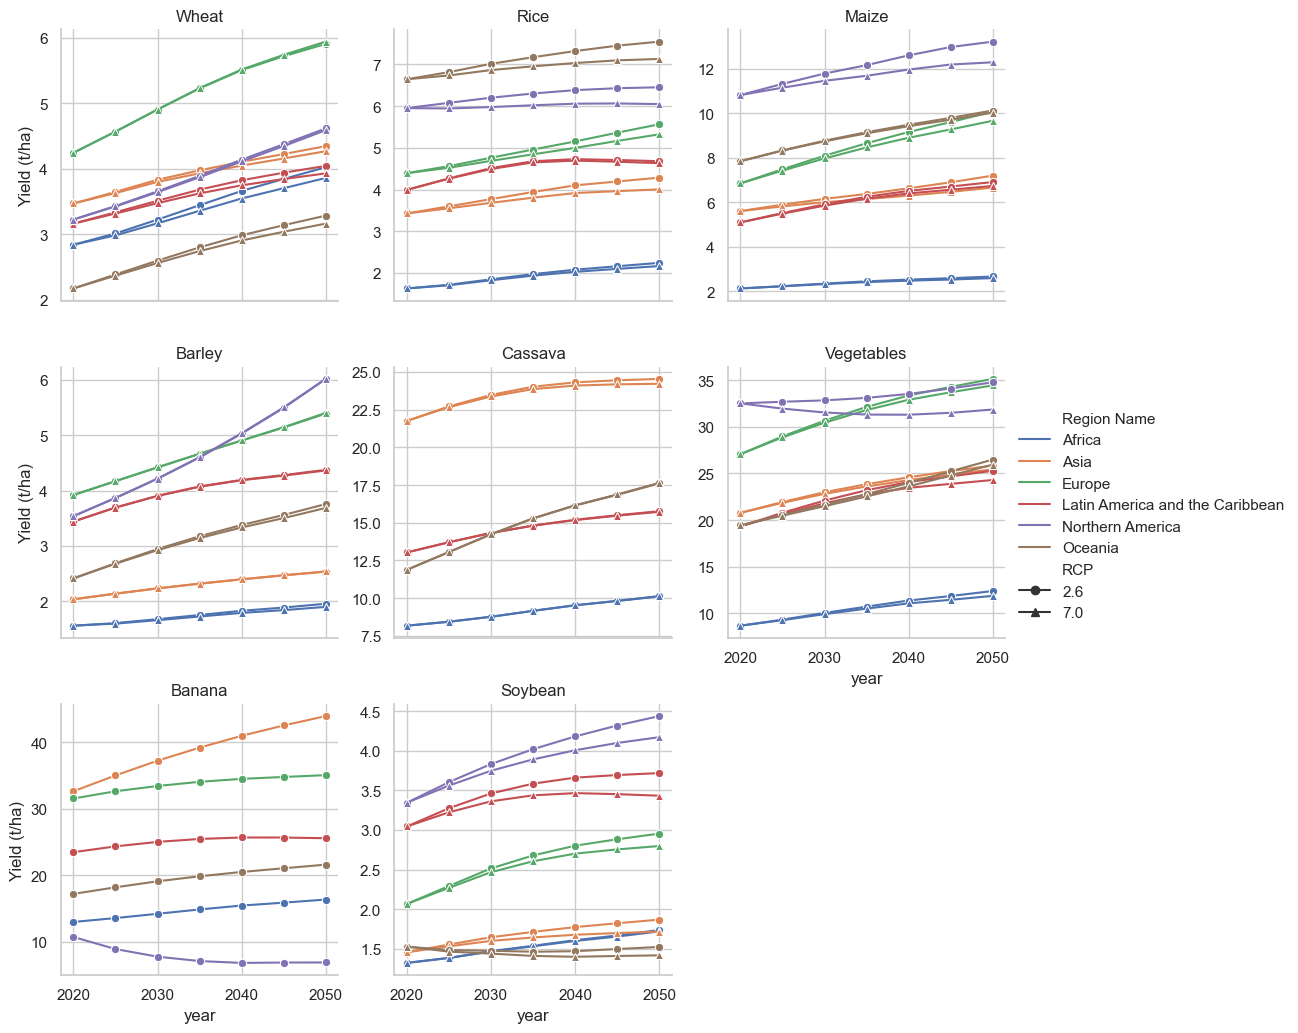

In [41]:
crop_dict = {'jwhea': 'Wheat', 
             'jrice': 'Rice', 
             'jmaiz': 'Maize', 
             'jbarl': 'Barley', 
             'jcass': 'Cassava', 
             'jvege': 'Vegetables', 
             'jbana': 'Banana', 
             'jsoyb': 'Soybean'}

yields = supply_scn_all.merge(country_input_all[['abbreviation', 'IMPACT_code', 'yield_t_ha', 'supply_q']])
yields['yield_t_ha'] = yields['yield_t_ha'] * yields['scaling_factor_yield']
yields['supply_q'] = yields['supply_q'] * yields['scaling_factor_supply']

yields['area'] = yields['supply_q'] / yields['yield_t_ha']
yields = yields.merge(regions.rename(columns={'Abbreviation': 'abbreviation'}))
yields = yields.groupby(['Region Name', 'RCP', 'year', 'IMPACT_code'])[['supply_q', 'area']].sum().reset_index()
yields['Yield (t/ha)'] = yields['supply_q'] / yields['area']
yields['RCP'] = yields['RCP'].astype(str)

g = sns.relplot(x='year', y='Yield (t/ha)', data=(yields[
    (yields['RCP'].isin(['2.6', '7.0']))].copy().assign(year=lambda d: d['year'].round().astype(int))), 
                kind='line', style='RCP', style_order=['2.6', '7.0'], markers =['o', '^'],
                hue='Region Name', col='IMPACT_code', col_wrap=3, col_order=crop_codes, 
                dashes=False, height=3.5, facet_kws=dict(sharex=True, sharey=False))

g.col_names = [crop_dict.get(n) for n in g.col_names]
g.set_titles(col_template="{col_name}") 

In [87]:
df_inp = country_input_all.merge(demand_scn_all[demand_scn_all['kcal_scn']=='2500kcal'])
df_inp['demand_q'] = df_inp['demand_q'] * df_inp['scaling_factor_demand']

df_inp = df_inp.merge(supply_scn_all)
df_inp['supply_q'] = df_inp['supply_q'] * df_inp['scaling_factor_supply']
df_inp['demand_q'] = df_inp['demand_q'] / 1e6
df_inp['supply_q'] = df_inp['supply_q'] / 1e6

In [88]:
df_inp_agg = df_inp.groupby(['diet_scn', 'year', 'RCP', 'IMPACT_code'])[['demand_q', 'supply_q']].sum().reset_index()
# df_inp_agg[df_inp_agg['RCP']=='NoCC'].pivot(index=['IMPACT_code', 'year', ], columns='diet_scn', values='demand_q').reset_index()

In [45]:
# global demand
df = country_output_all[(country_output_all['kcal_scn']=='2500kcal')].copy()
df['total_conprice'] = df['conprice'] * df['demand']
df = df.groupby(['IMPACT_code', 'year', 'diet_scn', 'RCP', 'lib_scn'])[['supply', 'demand', 'dom_supply', 'import', 'export', 'total_conprice']].sum().reset_index()
df['conprice'] = df['total_conprice'] / df['demand']
df['demand'] = df['demand'] / 1000
df['supply'] = df['supply'] / 1000
df['dom_supply'] = df['dom_supply'] / 1000
df['import'] = df['import'] / 1000
df['export'] = df['export'] / 1000
df['fraction_trade'] = df['import'] / df['demand']

In [46]:
# df[df['year']==2050][['IMPACT_code', 'year', 'RCP', 'diet_scn', 'lib_scn', 'demand']].rename(columns={'demand': 'demand_modelled'}).merge(
#     df_inp.rename(columns={'demand_q':'demand_from_scn'}))

In [47]:
df = df.melt(id_vars=['IMPACT_code', 'year', 'diet_scn', 'RCP', 'lib_scn'], 
             value_vars=['demand', 'conprice', 'fraction_trade'], var_name='metric', value_name='value')

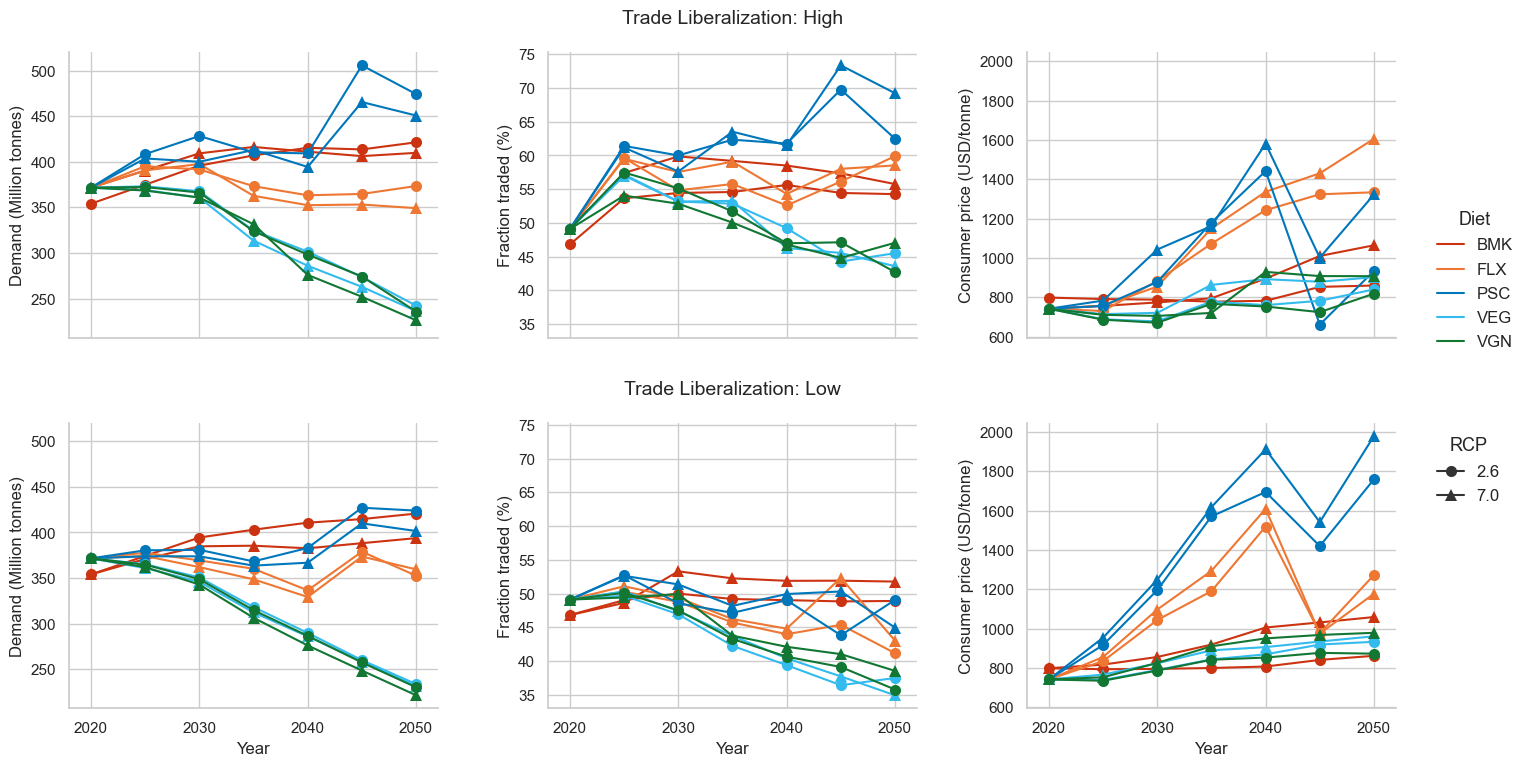

In [49]:
crop_code = 'jsoyb'

diets = ["BMK","FLX","PSC","VEG","VGN"]
palette = sns.color_palette(["#CC3311", "#EE7733", "#0077BB", "#33BBEE", "#117733"])
# #9352FE #ECE133
markers = {2.6:"o", 7:"^"}
row_order = ["high","low"]
col_order = ["demand","fraction_trade","conprice"]

titles = {
    "demand":"Demand",
    "fraction_trade":"Fraction traded",
    "conprice":"Consumer price",
}

ylabels = {
    "demand":"Demand (Million tonnes)",
    "fraction_trade":"Fraction traded (%)",  
    "conprice":"Consumer price (USD/tonne)",
}

df["diet_scn"] = pd.Categorical(df["diet_scn"], categories=diets, ordered=True)
df["lib_scn"] = pd.Categorical(df["lib_scn"], categories=row_order, ordered=True)
df["metric_label"] = pd.Categorical(df["metric"].map(titles), categories=[titles[m] for m in col_order], ordered=True)

sns.set_theme(style="whitegrid")
g = sns.relplot(
    data=df[df['IMPACT_code']==crop_code].sort_values(['diet_scn', 'RCP', 'lib_scn', "year"]),
    x="year", y="value",
    hue="diet_scn", palette=palette, hue_order=diets,
    style="RCP", style_order=list(markers.keys()),
    kind="line", markers=markers, dashes=False,
    row="lib_scn", row_order=row_order,
    col="metric_label", col_order=[titles[m] for m in col_order],
    height=3.8, aspect=1.25, facet_kws=dict(sharex=True, sharey='col')
    
)


# axes formatting: decade ticks, markers at every point, y-labels & percent formatter
for i, trade in enumerate(row_order):
    for j, m in enumerate(col_order):
        ax = g.axes[i, j]
        ax.set_xticks([2020, 2030, 2040, 2050])
        ax.set_xlim(2018, 2052)

        for line in ax.lines:
            line.set_markersize(8)
            line.set_markeredgewidth(0)

        # y labels per column
        ax.set_ylabel(ylabels[m])
        ax.set_xlabel("Year" if i==len(row_order)-1 else "")

        if m == "fraction_trade":
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0, symbol=''))

g.set_titles("")
fig = g.fig

fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, trade in enumerate(row_order):
    ax0 = g.axes[i, 1]
    pos = ax0.get_position()  # figure coords
    x_center = pos.x0 + pos.width/2
    fig.text(x_center, 0.42+pos.y0, f"Trade Liberalization: {trade.capitalize()}",
             ha="center", va="center", fontsize=14)


leg = getattr(g, "_legend", None)
if leg is not None:
    handles = getattr(leg, "legend_handles", None) or getattr(leg, "legendHandles", None)
    labels  = [t.get_text() for t in leg.texts]
    leg.remove()
else:
    ax0 = g.axes.flat[0]
    handles, labels = ax0.get_legend_handles_labels()

seen = set()
H, L = [], []
for h, lab in zip(handles, labels):
    if lab and (lab not in seen):
        seen.add(lab)
        H.append(h); L.append(lab)

handle_by_label = {lab: h for h, lab in zip(H, L)}

diet_h = [handle_by_label[d] for d in diets if d in handle_by_label]
diet_l = diets

rcp_h  = [handle_by_label[r] for r in ['2.6', '7'] if r in handle_by_label]
rcp_l  = ['2.6', '7.0']

for h in rcp_h:
    h.set_markersize(8)     
    # h.set_linewidth(0)      
    h.set_markeredgewidth(0)

leg1 = fig.legend(
    diet_h, diet_l, title="Diet",
    loc="center left", bbox_to_anchor=(0.94, 0.65), bbox_transform=fig.transFigure,
    frameon=False, ncol=1, labelspacing=0.6, handlelength=1.8, borderaxespad=0.0
)
leg2 = fig.legend(
    rcp_h, rcp_l, title="RCP",
    loc="center left", bbox_to_anchor=(0.94, 0.4), bbox_transform=fig.transFigure,
    frameon=False, ncol=1, labelspacing=0.6, handlelength=1.8, borderaxespad=0.0
)

plt.setp(leg1.get_title(), fontsize=13) 
plt.setp(leg2.get_title(), fontsize=13)
for txt in leg1.get_texts() + leg2.get_texts():
    txt.set_fontsize(12)

# plt.tight_layout()

plt.show()

In [89]:
df_inp_agg[(df_inp_agg['year']==2050)
       # & (df_inp_agg['diet_scn']=='FLX')
       & (df_inp_agg['RCP'].isin(['2.6', '7.0']))
       & (df_inp_agg['IMPACT_code']==crop_code)]

,diet_scn,year,RCP,IMPACT_code,demand_q,supply_q
197,BMK,2050,2.6,jsoyb,430.347431,465.554002
205,BMK,2050,7.0,jsoyb,430.347431,456.222157
421,FLX,2050,2.6,jsoyb,398.798753,465.554002
429,FLX,2050,7.0,jsoyb,398.798753,456.222157
645,FLX_hmilk,2050,2.6,jsoyb,373.201731,465.554002
653,FLX_hmilk,2050,7.0,jsoyb,373.201731,456.222157
869,FLX_hredmeat,2050,2.6,jsoyb,414.269087,465.554002
877,FLX_hredmeat,2050,7.0,jsoyb,414.269087,456.222157
1093,PSC,2050,2.6,jsoyb,509.536096,465.554002
1101,PSC,2050,7.0,jsoyb,509.536096,456.222157


In [95]:
df_inp = df_inp[['abbreviation', 'IMPACT_code', 'kcal_scn', 'diet_scn', 'SSP_scn', 'year', 'RCP', 
                 'demand_q', 'supply_q']]

In [100]:
d = country_output_all.copy()
d['RCP'] = d['RCP'].astype(str)
d = df_inp.merge(d)
d['demand'] = d['demand'] / 1e3
d['supply'] = d['supply'] / 1e3

In [111]:
d['demand_diff'] = d['demand'] - d['demand_q']
d['supply_diff'] = d['supply'] - d['supply_q']
d.describe()

,year,demand_q,supply_q,supply,demand,dom_supply,import,export,prodprice,conprice,B_value,D_value,con_surplus_mUSD,prod_surplus_mUSD,demand_diff,supply_diff
count,159950.000000,1.599500e+05,159950.000000,159950.000000,159950.000000,159950.000000,159950.000000,159950.000000,1.599500e+05,159950.000000,159950.000000,1.599500e+05,159950.000000,159950.000000,159950.000000,159950.000000
mean,2035.000000,4.457598e+00,4.839899,4.213484,4.213484,3243.152769,970.331514,970.331514,5.427630e+02,630.082838,91.155287,1.101580e+02,5.837110,2.166977,-0.244114,-0.626414
std,10.000031,2.647785e+01,29.800365,25.098027,24.297219,22866.156092,4164.287018,4655.923141,4.015354e+02,396.888241,311.936491,4.085750e+02,48.391069,23.226844,3.563220,8.804894
min,2020.000000,4.000000e-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.759118e-09,20.461373,0.003217,8.649415e-11,0.000000,0.000000,-223.026478,-426.252898
25%,2025.000000,3.834657e-02,0.000000,0.013181,0.058694,2.988261,16.269712,0.002256,2.867810e+02,379.234968,1.079443,6.050259e-01,0.055072,0.004251,-0.040692,-0.025131
50%,2035.000000,3.720423e-01,0.102874,0.168860,0.400136,84.348490,126.305044,10.141998,4.014815e+02,482.411834,5.351753,7.782727e+00,0.429968,0.093646,-0.000437,0.001904
75%,2045.000000,2.189509e+00,1.432198,1.340659,2.105585,903.156769,652.535480,190.582496,6.713524e+02,767.381567,33.241143,3.478277e+01,2.305705,0.626256,0.019957,0.039942
max,2050.000000,8.742628e+02,764.191810,899.783746,768.334090,716452.005081,308937.510834,226710.861901,2.885178e+03,3137.839923,10009.508815,1.629438e+04,3647.573158,2142.443387,57.397829,226.942782


In [118]:
d[d['IMPACT_code']=='jvege'].sort_values('supply_diff').tail()[['abbreviation', 'IMPACT_code',
                                                                'diet_scn', 'year', 'RCP',
                                                                'demand_q', 'supply_q', 
                                                                'demand', 'supply',
                                                                'demand_diff', 'supply_diff']]

,abbreviation,IMPACT_code,diet_scn,year,RCP,demand_q,supply_q,demand,supply,demand_diff,supply_diff
109859,CHM,jvege,VGN,2040,7.0,811.102178,692.975311,698.530920,803.140922,-112.571257,110.165610
109809,CHM,jvege,PSC,2030,2.6,676.577413,660.712468,666.491565,775.834861,-10.085848,115.122393
115079,IND,jvege,VGN,2050,7.0,558.702208,307.856892,364.884420,425.097714,-193.817788,117.240821
109801,CHM,jvege,BMK,2030,2.6,650.020838,660.712468,707.418667,846.285657,57.397829,185.573189
109839,CHM,jvege,VGN,2035,7.0,776.275358,672.840963,718.759362,899.783746,-57.515996,226.942782


In [202]:
df = trade_output_all.groupby(['from_region', 'to_region', 'year', 'IMPACT_code', 'diet_scn', 'lib_scn', 'RCP'])[['trade']].sum().reset_index()
df['trade'] = df['trade']/1000 # million tonnes
df.shape

(5040, 8)

In [203]:
df[(df['diet_scn']=='BMK') & (df['RCP']==2.6) & (df['year'].isin([2020, 2030, 2040, 2050]))].sort_values(by='trade').tail()

,from_region,to_region,year,IMPACT_code,diet_scn,lib_scn,RCP,trade
1022,Asia,Asia,2030,jwhea,BMK,low,2.6,384.358288
1060,Asia,Asia,2040,jwhea,BMK,high,2.6,387.249102
1100,Asia,Asia,2050,jwhea,BMK,high,2.6,394.864890
1062,Asia,Asia,2040,jwhea,BMK,low,2.6,401.414616
1102,Asia,Asia,2050,jwhea,BMK,low,2.6,412.072332


In [204]:
df.loc[df['from_region']==df['to_region'], 'trade'] = 0

/Users/shruti/anaconda3/envs/ifpri/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


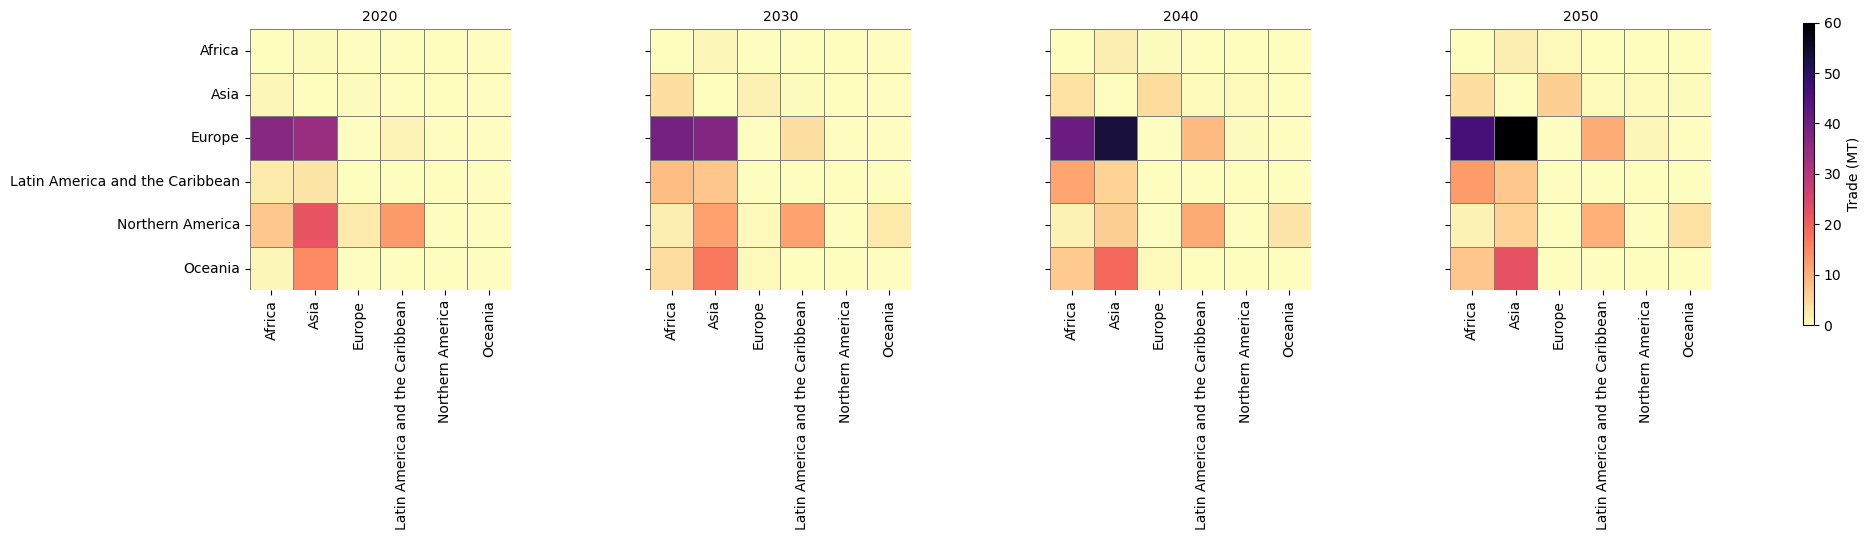

In [205]:
cmap = sns.color_palette("magma_r", as_cmap=True)

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index='from_region', columns='to_region', values='trade')
    sns.heatmap(d, cmap=cmap, vmin=vmin, vmax=vmax, 
                cbar=False, square=True, linewidth=0.4, linecolor='gray')

subset = df[
    (df['diet_scn'] == 'BMK') &
    (df['RCP'] == 2.6) &
    (df['lib_scn'] == 'low') &
    (df['year'].isin([2020, 2030, 2040, 2050]))
].copy()

vmin = subset['trade'].min()
vmax = subset['trade'].max()

g = sns.FacetGrid(subset, col='year', sharey=True, height=5.5, aspect=1)
g.map_dataframe(draw_heatmap)

g.set_titles(col_template="{col_name}")  

g.set_axis_labels('', '')
for ax in g.axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=90)

# one common colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # compatibility
cbar_ax = g.fig.add_axes([0.85, 0.4, 0.005, 0.55])  # x, y, width, height
g.fig.colorbar(sm, cax=cbar_ax, label='Trade (MT)')

# leave room for the colorbar
g.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

/Users/shruti/anaconda3/envs/ifpri/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


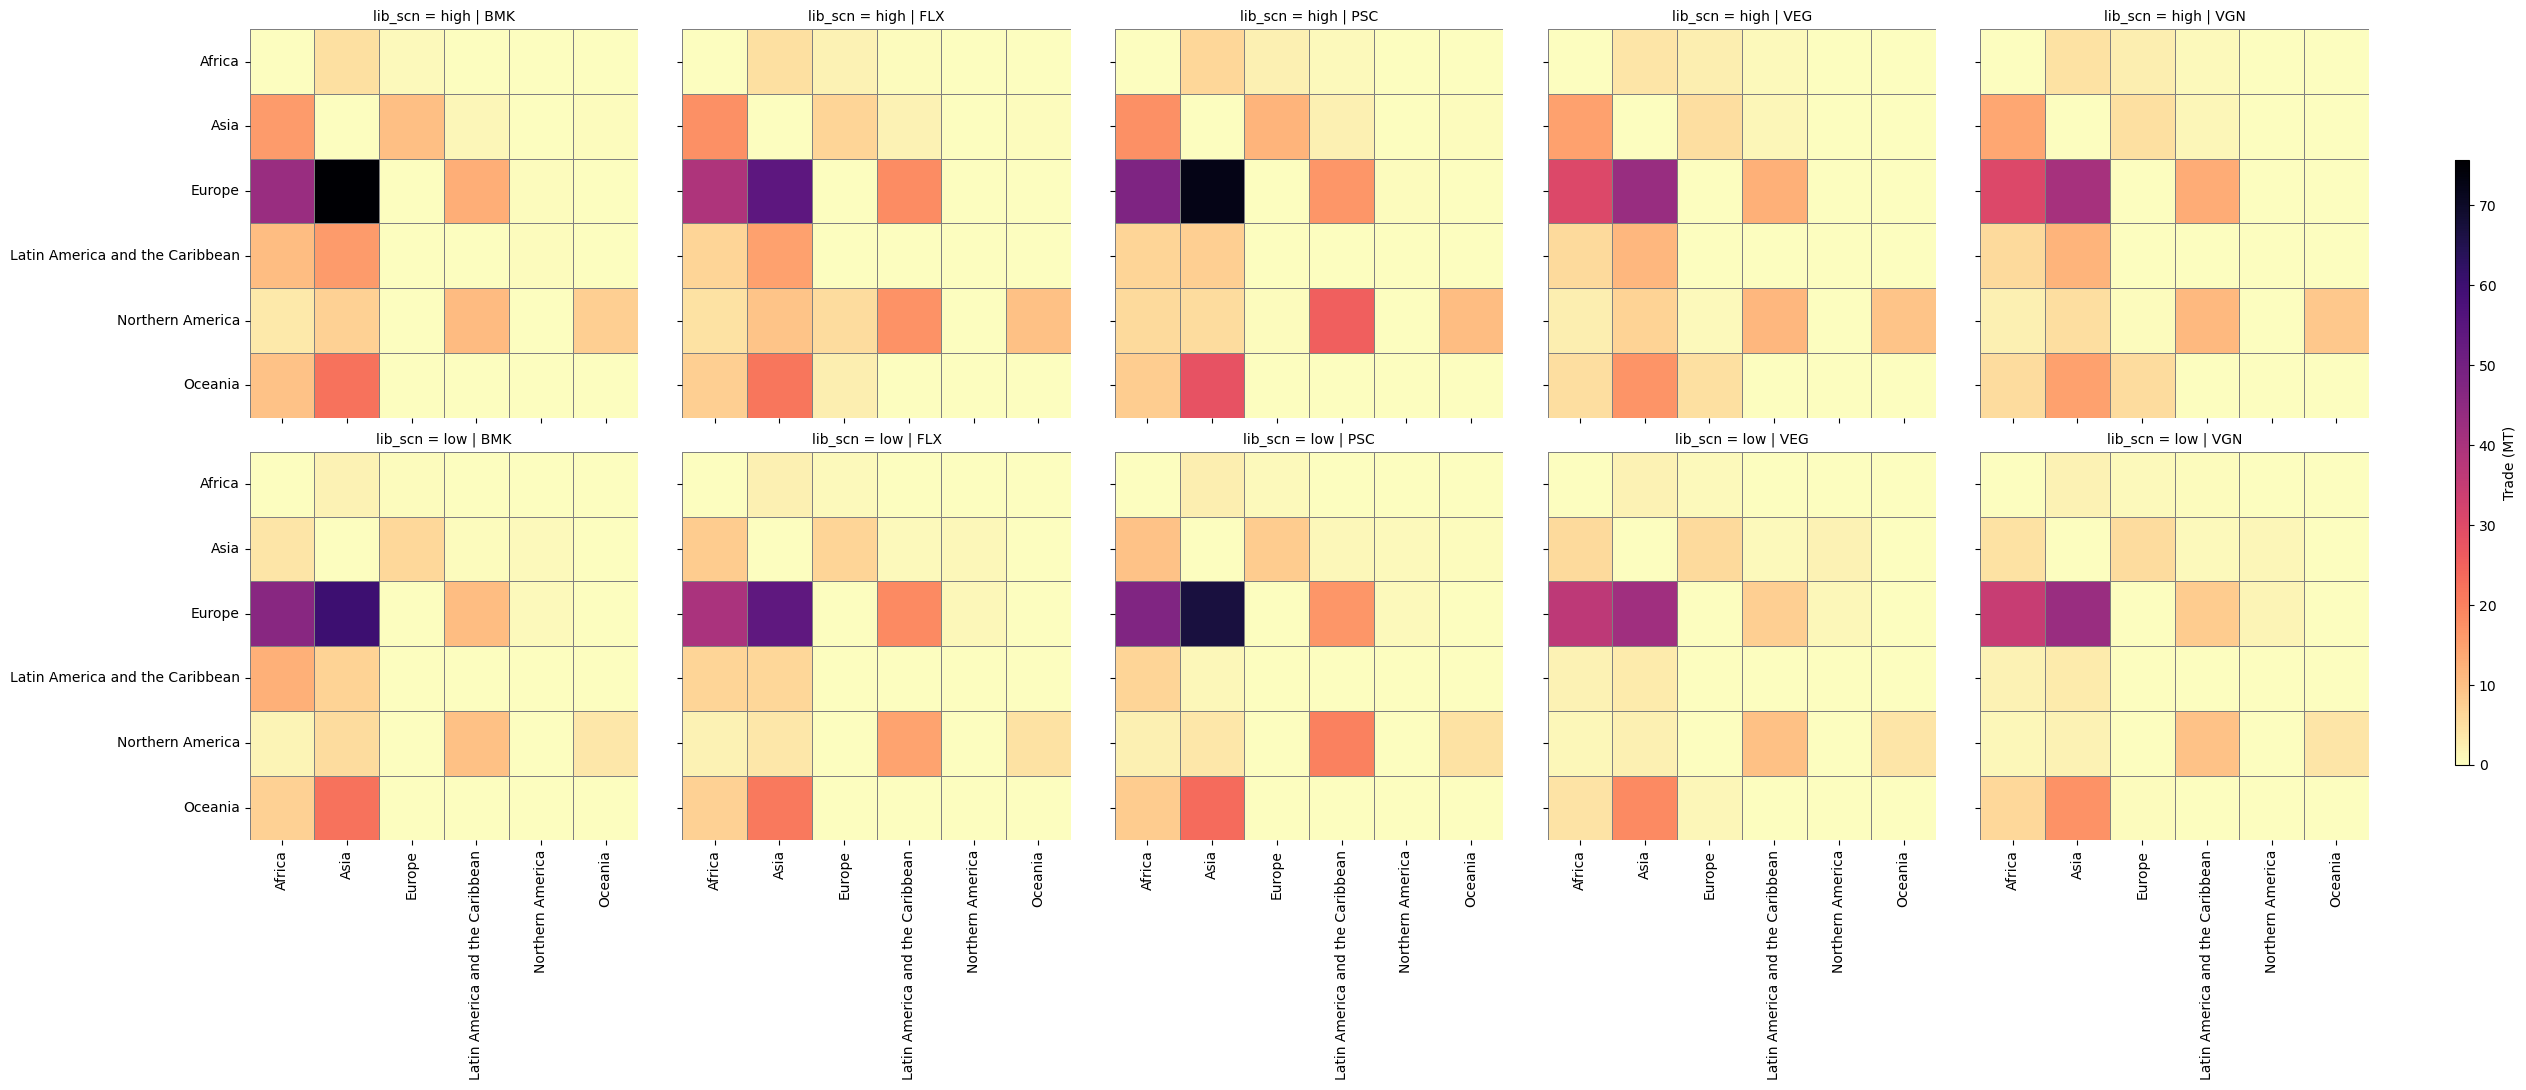

In [217]:
cmap = sns.color_palette("magma_r", as_cmap=True)

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index='from_region', columns='to_region', values='trade')
    sns.heatmap(d, cmap=cmap, vmin=vmin, vmax=vmax, 
                cbar=False, square=True, linewidth=0.4, linecolor='gray')

subset = df[
    (df['year'] == 2050) &
    (df['RCP'] == 2.6)
].copy()

vmin = subset['trade'].min()
vmax = subset['trade'].max()

g = sns.FacetGrid(subset, col='diet_scn', row='lib_scn', sharey=True, sharex=True, height=5.5, aspect=1)
g.map_dataframe(draw_heatmap)

g.set_titles(col_template="{col_name}")

g.set_axis_labels('', '')
for ax in g.axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=90)

# one common colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # compatibility
cbar_ax = g.fig.add_axes([0.9, 0.3, 0.005, 0.55])  # x, y, width, height
g.fig.colorbar(sm, cax=cbar_ax, label='Trade (MT)')

# leave room for the colorbar
g.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

/Users/shruti/anaconda3/envs/ifpri/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


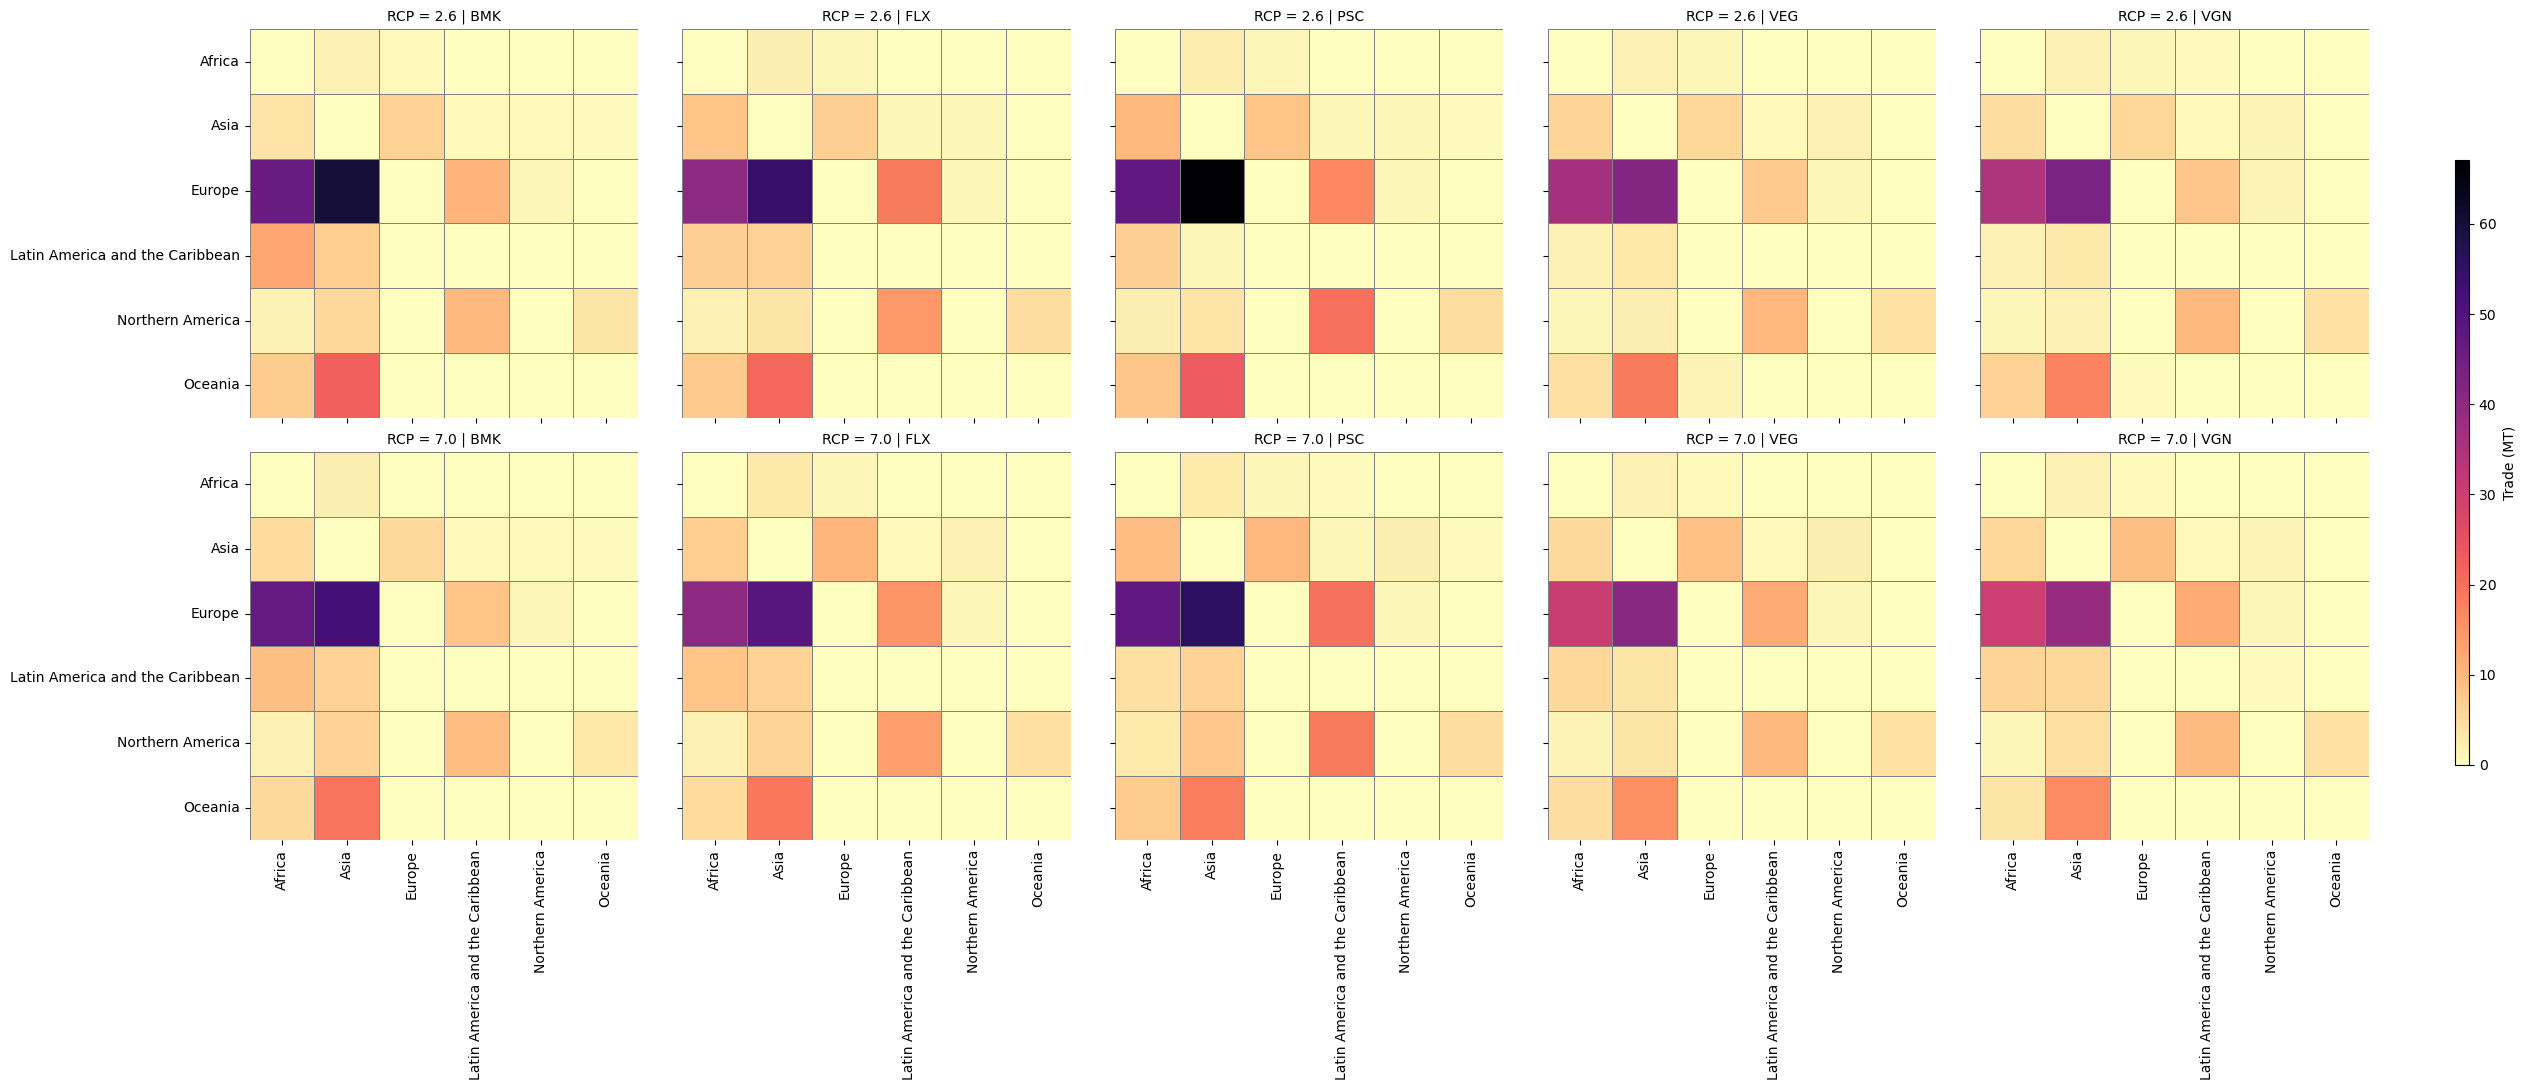

In [218]:
cmap = sns.color_palette("magma_r", as_cmap=True)

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index='from_region', columns='to_region', values='trade')
    sns.heatmap(d, cmap=cmap, vmin=vmin, vmax=vmax, 
                cbar=False, square=True, linewidth=0.4, linecolor='gray')

subset = df[
    (df['year'] == 2050) &
    (df['lib_scn'] == 'low')
].copy()

vmin = subset['trade'].min()
vmax = subset['trade'].max()

g = sns.FacetGrid(subset, col='diet_scn', row='RCP', sharey=True, sharex=True, height=5.5, aspect=1)
g.map_dataframe(draw_heatmap)

g.set_titles(col_template="{col_name}")

g.set_axis_labels('', '')
for ax in g.axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=90)

# one common colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # compatibility
cbar_ax = g.fig.add_axes([0.9, 0.3, 0.005, 0.55])  # x, y, width, height
g.fig.colorbar(sm, cax=cbar_ax, label='Trade (MT)')

# leave room for the colorbar
g.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()